# AlexNet

In [1]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Data and Preprocessing 

In [2]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

# Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train data
actual labels: ['Normal', 'Lung_Opacity', 'COVID', 'Lung_Opacity']
numerical labels: tensor([2, 1, 0, 1])


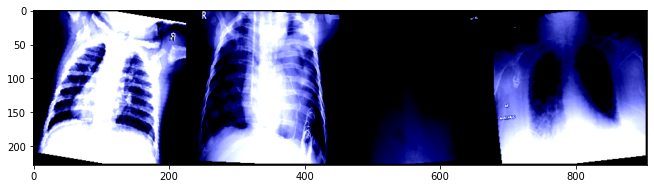

In [3]:
print('train data')
show_img(datas[0])

In [4]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 2, 2, 2, 1, 2, 2, 1, 1, 1])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([0, 2, 2, 1, 3, 2, 2, 2, 1, 0])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 1, 2, 2, 1, 2, 2, 1, 0, 0])


In [5]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# AlexNet

## Settings

In [11]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 25

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [12]:
DEVICE

device(type='cuda')

# Pretrained AlexNet: fine tuned fc layer

In [14]:
model_ft = torchvision.models.alexnet(pretrained=True)
# model.classifier[4] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 4)
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
model_ft

torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/025 | Batch 0000/0339 | Loss: 1.3453
Epoch: 001/025 | Batch 0050/0339 | Loss: 0.5972
Epoch: 001/025 | Batch 0100/0339 | Loss: 0.4544
Epoch: 001/025 | Batch 0150/0339 | Loss: 0.4769
Epoch: 001/025 | Batch 0200/0339 | Loss: 0.4988
Epoch: 001/025 | Batch 0250/0339 | Loss: 0.3900
Epoch: 001/025 | Batch 0300/0339 | Loss: 0.7204
Epoch: 001/025 | Train: 81.40% | Validation: 81.79%
Time elapsed: 5.39 min
Epoch: 002/025 | Batch 0000/0339 | Loss: 0.4927
Epoch: 002/025 | Batch 0050/0339 | Loss: 0.4772
Epoch: 002/025 | Batch 0100/0339 | Loss: 0.5617
Epoch: 002/025 | Batch 0150/0339 | Loss: 0.4109
Epoch: 002/025 | Batch 0200/0339 | Loss: 0.4861
Epoch: 002/025 | Batch 0250/0339 | Loss: 0.3712
Epoch: 002/025 | Batch 0300/0339 | Loss: 0.4924
Epoch: 002/025 | Train: 86.13% | Validation: 86.08%
Time elapsed: 10.80 min
Epoch: 003/025 | Batch 0000/0339 | Loss: 0.4909
Epoch: 003/025 | Batch 0050/0339 | Loss: 0.4469
Epoch: 003/025 | Batch 0100/0339 | Loss: 0.4211
Epoch: 003/025 | Batch 0150/0339 

Epoch: 021/025 | Batch 0000/0339 | Loss: 0.2305
Epoch: 021/025 | Batch 0050/0339 | Loss: 0.4306
Epoch: 021/025 | Batch 0100/0339 | Loss: 0.3421
Epoch: 021/025 | Batch 0150/0339 | Loss: 0.3162
Epoch: 021/025 | Batch 0200/0339 | Loss: 0.2267
Epoch: 021/025 | Batch 0250/0339 | Loss: 0.3317
Epoch: 021/025 | Batch 0300/0339 | Loss: 0.2653
Epoch: 021/025 | Train: 91.22% | Validation: 89.40%
Time elapsed: 117.46 min
Epoch: 022/025 | Batch 0000/0339 | Loss: 0.3266
Epoch: 022/025 | Batch 0050/0339 | Loss: 0.2863
Epoch: 022/025 | Batch 0100/0339 | Loss: 0.2539
Epoch: 022/025 | Batch 0150/0339 | Loss: 0.2483
Epoch: 022/025 | Batch 0200/0339 | Loss: 0.2424
Epoch: 022/025 | Batch 0250/0339 | Loss: 0.2691
Epoch: 022/025 | Batch 0300/0339 | Loss: 0.1932
Epoch: 022/025 | Train: 91.56% | Validation: 90.14%
Time elapsed: 122.94 min
Epoch: 023/025 | Batch 0000/0339 | Loss: 0.3606
Epoch: 023/025 | Batch 0050/0339 | Loss: 0.2975
Epoch: 023/025 | Batch 0100/0339 | Loss: 0.4323
Epoch: 023/025 | Batch 0150/03

# Evaluation AlexNet: fine tuned fc

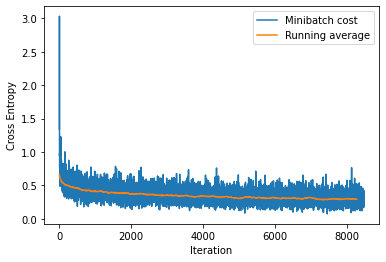

In [15]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

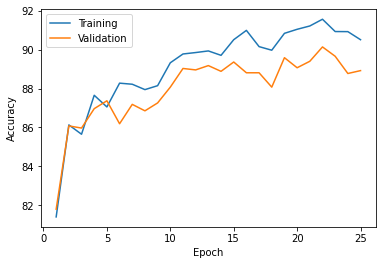

In [16]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

# Pretrained AlexNet fine tune fc layer + last conv layer

In [18]:
model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/025 | Batch 0000/0339 | Loss: 1.4418
Epoch: 001/025 | Batch 0050/0339 | Loss: 0.5812
Epoch: 001/025 | Batch 0100/0339 | Loss: 0.4937
Epoch: 001/025 | Batch 0150/0339 | Loss: 0.4578
Epoch: 001/025 | Batch 0200/0339 | Loss: 0.5665
Epoch: 001/025 | Batch 0250/0339 | Loss: 0.3516
Epoch: 001/025 | Batch 0300/0339 | Loss: 0.6213
Epoch: 001/025 | Train: 81.08% | Validation: 81.54%
Time elapsed: 5.52 min
Epoch: 002/025 | Batch 0000/0339 | Loss: 0.4378
Epoch: 002/025 | Batch 0050/0339 | Loss: 0.4992
Epoch: 002/025 | Batch 0100/0339 | Loss: 0.5960
Epoch: 002/025 | Batch 0150/0339 | Loss: 0.3260
Epoch: 002/025 | Batch 0200/0339 | Loss: 0.4242
Epoch: 002/025 | Batch 0250/0339 | Loss: 0.4494
Epoch: 002/025 | Batch 0300/0339 | Loss: 0.5944
Epoch: 002/025 | Train: 85.17% | Validation: 84.71%
Time elapsed: 10.98 min
Epoch: 003/025 | Batch 0000/0339 | Loss: 0.4552
Epoch: 003/025 | Batch 0050/0339 | Loss: 0.4138
Epoch: 003/025 | Batch 0100/0339 | Loss: 0.3896
Epoch: 003/025 | Batch 0150/0339 

Epoch: 021/025 | Batch 0000/0339 | Loss: 0.2419
Epoch: 021/025 | Batch 0050/0339 | Loss: 0.4369
Epoch: 021/025 | Batch 0100/0339 | Loss: 0.3480
Epoch: 021/025 | Batch 0150/0339 | Loss: 0.3395
Epoch: 021/025 | Batch 0200/0339 | Loss: 0.3042
Epoch: 021/025 | Batch 0250/0339 | Loss: 0.3268
Epoch: 021/025 | Batch 0300/0339 | Loss: 0.2303
Epoch: 021/025 | Train: 90.40% | Validation: 88.81%
Time elapsed: 117.45 min
Epoch: 022/025 | Batch 0000/0339 | Loss: 0.4375
Epoch: 022/025 | Batch 0050/0339 | Loss: 0.2567
Epoch: 022/025 | Batch 0100/0339 | Loss: 0.2372
Epoch: 022/025 | Batch 0150/0339 | Loss: 0.2329
Epoch: 022/025 | Batch 0200/0339 | Loss: 0.2815
Epoch: 022/025 | Batch 0250/0339 | Loss: 0.3028
Epoch: 022/025 | Batch 0300/0339 | Loss: 0.1825
Epoch: 022/025 | Train: 90.79% | Validation: 89.70%
Time elapsed: 122.90 min
Epoch: 023/025 | Batch 0000/0339 | Loss: 0.3674
Epoch: 023/025 | Batch 0050/0339 | Loss: 0.2738
Epoch: 023/025 | Batch 0100/0339 | Loss: 0.5375
Epoch: 023/025 | Batch 0150/03

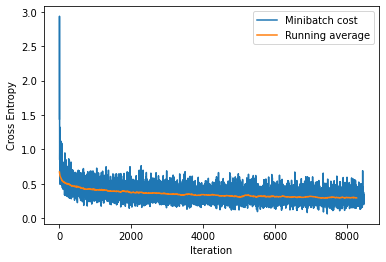

In [19]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

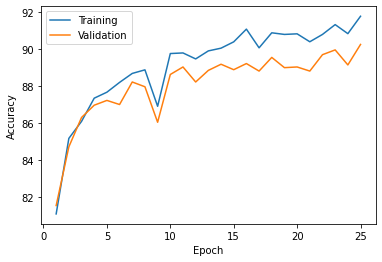

In [20]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model_ft,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model_ft,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model_ft,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 91.72%
Validation ACC: 89.92%
Test ACC: 88.99%
